# Neural Architecture Search (NAS) Strategies

This notebook demonstrates different Neural Architecture Search (NAS) strategies for finding optimal neural network architectures. We'll implement and compare the following approaches:

1. **Random Search** - Efficient sampling with NumPy (ToDo during the workshop)
2. **Reinforcement Learning** - Policy Gradient and Q-learning approaches
3. **Evolutionary Search** - Simple Genetic Algorithm
4. **Gradient-Based Search** - DARTS (Differentiable Architecture Search) with first-order approximations

Each strategy will be evaluated on accuracy and inference time.

### CIFAR-10 Dataset
The dataset is the CIFAR-10 data, which is widely used to train machine learning and computer vision algorithms and research. It is a multi-class dataset. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. 

## 1. Setup and Imports

First, let's import the necessary libraries and set up our environment.

In [2]:
import sys
import os

# Add the project root (one level above 'src') to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Import our custom modules
from src.library.nas.search_space import SearchSpace
from src.library.nas.utils_2 import get_dataset, train_model, evaluate_model, get_best_torch_device, plot_comparison_results
from src.library.nas.random_search import RandomSearch
from src.library.nas.reinforcement_learning_search import ReinforcementLearningSearch
from src.library.nas.evolutionary_search import EvolutionarySearch
from src.library.nas.darts_search import DARTSSearch

## 2. Search Space Definition

The search space defines the possible neural network architectures that our NAS strategies will explore. Our search space includes:

- Different convolutional operations (3x3, 5x5, 7x7 convolutions, max/avg pooling)
- Various channel sizes
- Different activation functions
- Pooling operations
- Fully connected layer sizes and dropout rates
- Variable number of layers

Let's examine our search space:

In [4]:
# Initialize the search space
search_space = SearchSpace()

# Print search space details
print("Search Space Details:")
print(f"Convolutional Operations: {[op[0] for op in search_space.conv_ops]}")
print(f"Channel Choices: {search_space.channel_choices}")
print(f"Number of Layers Range: {search_space.num_layers_range}")
print(f"Activation Functions: {[act[0] for act in search_space.activation_ops]}")
print(f"Pooling Operations: {[pool[0] for pool in search_space.pooling_ops]}")
print(f"FC Layer Sizes: {search_space.fc_sizes}")
print(f"Dropout Rates: {search_space.dropout_rates}")

Search Space Details:
Convolutional Operations: ['conv3x3', 'conv5x5', 'max_pool3x3', 'avg_pool3x3']
Channel Choices: [16, 32, 64, 128]
Number of Layers Range: (2, 6)
Activation Functions: ['relu', 'leaky_relu', 'elu', 'selu']
Pooling Operations: ['max_pool2x2', 'avg_pool2x2']
FC Layer Sizes: [128, 256, 512, 1024]
Dropout Rates: [0.0, 0.2, 0.3, 0.5]


Let's sample a random architecture from our search space to understand its structure:

In [10]:
random_architecture = search_space.sample_simple_architecture()

# Print architecture details
print("Random Architecture Sample:")
print("\nConvolutional Layers:")
for i, layer in enumerate(random_architecture['conv_layers']):
    print(f"Layer {i+1}:")
    print(f"  Operation: {layer['op']}")
    print(f"  Channels: {layer['in_channels']} -> {layer['out_channels']}")
    print(f"  Activation: {layer['activation']}")
    print(f"  Pooling: {layer['pooling'] if layer['use_pooling'] else 'None'}")

print("\nFully Connected Layers:")
for i, layer in enumerate(random_architecture['fc_layers']):
    print(f"Layer {i+1}:")
    print(f"  Size: {layer['in_features']} -> {layer['out_features']}")
    print(f"  Activation: {layer['activation'] if layer['activation'] else 'None'}")
    print(f"  Dropout: {layer['dropout_rate']}")

Random Architecture Sample:

Convolutional Layers:
Layer 1:
  Operation: avg_pool3x3
  Channels: 3 -> 16
  Activation: selu
  Pooling: avg_pool2x2
Layer 2:
  Operation: conv5x5
  Channels: 16 -> 32
  Activation: leaky_relu
  Pooling: avg_pool2x2
Layer 3:
  Operation: avg_pool3x3
  Channels: 32 -> 64
  Activation: relu
  Pooling: max_pool2x2

Fully Connected Layers:
Layer 1:
  Size: 1024 -> 10
  Activation: None
  Dropout: 0.5


In [ ]:
# TODO: Sample a random architecture
random_architecture = # implementation here

# Print architecture details
print("Random Architecture Sample:")
print("\nConvolutional Layers:")
for i, layer in enumerate(random_architecture['conv_layers']):
    print(f"Layer {i+1}:")
    print(f"  Operation: {layer['op']}")
    print(f"  Channels: {layer['in_channels']} -> {layer['out_channels']}")
    print(f"  Activation: {layer['activation']}")
    print(f"  Pooling: {layer['pooling'] if layer['use_pooling'] else 'None'}")

print("\nFully Connected Layers:")
for i, layer in enumerate(random_architecture['fc_layers']):
    print(f"Layer {i+1}:")
    print(f"  Size: {layer['in_features']} -> {layer['out_features']}")
    print(f"  Activation: {layer['activation'] if layer['activation'] else 'None'}")
    print(f"  Dropout: {layer['dropout_rate']}")

Let's build a model from this architecture and check its structure:

In [ ]:
# TODO: Build a model from the random architecture
random_model = # implementation here

# Print model summary
print(random_model)

## 3. Evaluation Framework

Before diving into the NAS strategies, let's set up our evaluation framework. We'll use the CIFAR-10 dataset and evaluate models based on accuracy and inference time.

In [ ]:
# Get the best available device (GPU, MPS, or CPU)
device = get_best_torch_device()
print(f"Using device: {device}")

# Load datasets with a small subset for faster evaluation during NAS
train_loader, val_loader, test_loader = get_dataset(batch_size=64, small_subset=True)

# Print dataset information
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Let's test our evaluation framework by training and evaluating the random model:

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(random_model.parameters(), lr=0.001)

# Train the model for a few epochs
history = train_model(
    model=random_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=2,  # test
    verbose=True
)

In [ ]:
# Evaluate the model
eval_results = evaluate_model(
    model=random_model,
    test_loader=test_loader,
    device=device,
    verbose=True
)

## 4. Random Search Strategy

Random search is one of the simplest NAS strategies, but equally effective. It involves randomly sampling architectures from the search space and evaluating them.

### 4.1 Theory

Random search works by:
1. Sampling random architectures from the search space
2. Training and evaluating each architecture
3. Selecting the best performing architecture

Despite its simplicity, random search has several advantages:
- Simple to implement and parallelize
- No assumptions about the search space
- Can find good architectures with enough samples
- Provides a strong baseline for comparing other methods

### 4.2 Implementation

In [ ]:
# TODO: Initialize random search
random_search = RandomSearch(
    # Implement the required parameters for RandomSearch
)

In [ ]:
# Perform random search
best_random_architecture, best_random_model = random_search.search(verbose=True)

In [ ]:
# Plot search results
random_search.plot_search_results()

In [ ]:
# Get a summary of the best architecture found
print(random_search.get_best_architecture_summary())

In [ ]:
# TODO: Evaluate the model
eval_results = evaluate_model(
    # implementation here
)

## 5. Reinforcement Learning Strategies

Reinforcement Learning (RL) is a powerful approach for NAS, where an agent learns to design neural architectures through trial and error.

### 5.1 Theory

In RL-based NAS:
- A controller (agent) generates neural architectures
- The performance of each architecture (e.g., validation accuracy) serves as the reward
- The controller learns to maximize the expected reward by generating better architectures

We'll implement two RL approaches:
1. **Policy Gradient (REINFORCE)**: Directly learns a policy to generate architectures
2. **Q-Learning**: Learns the value of architecture decisions

### 5.2 Policy Gradient Implementation

In [18]:
# Initialize policy gradient search
policy_gradient_search = ReinforcementLearningSearch(
    search_space=search_space,
    method='policy_gradient',
    num_episodes=10,  # Number of episodes/iterations
    epochs_per_model=2,  # Number of epochs to train each model
    batch_size=64,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [7]:
# Perform policy gradient search
best_pg_architecture, best_pg_model = policy_gradient_search.search(verbose=True)

Starting Policy Gradient Search with 10 episodes...


 50%|█████     | 5/10 [15:37<16:48, 201.68s/it]

Episode 5/10, Best accuracy: 38.00%


100%|██████████| 10/10 [29:59<00:00, 179.90s/it]

Episode 10/10, Best accuracy: 41.00%
Policy Gradient Search completed in 29.98 minutes
Best architecture accuracy: 41.00%


In [19]:
# Plot search results
policy_gradient_search.plot_search_results()

No search results to plot. Run search() first.


In [9]:
# Get a summary of the best architecture found
print(policy_gradient_search.get_best_architecture_summary())

Best Architecture Summary (policy_gradient):
Accuracy: 41.00%

Convolutional Layers:
Layer 1:
  Operation: conv5x5
  Channels: 3 -> 32
  Activation: relu
  Pooling: None
Layer 2:
  Operation: max_pool3x3
  Channels: 32 -> 128
  Activation: elu
  Pooling: None

Fully Connected Layers:
Layer 1:
  Size: 131072 -> 10
  Activation: None
  Dropout: 0.3



### 5.3 Q-Learning Implementation

In [10]:
# Initialize Q-learning search
q_learning_search = ReinforcementLearningSearch(
    search_space=search_space,
    method='q_learning',
    num_episodes=10,  # Number of episodes/iterations
    epochs_per_model=5,  # Number of epochs to train each model
    batch_size=64,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [11]:
# Perform Q-learning search
best_ql_architecture, best_ql_model = q_learning_search.search(verbose=True)

Starting Q-Learning Search with 10 episodes...


 50%|█████     | 5/10 [14:27<14:25, 173.09s/it]

Episode 5/10, Epsilon: 0.9752, Best accuracy: 38.00%


100%|██████████| 10/10 [28:46<00:00, 172.68s/it]

Episode 10/10, Epsilon: 0.9511, Best accuracy: 38.00%
Q-Learning Search completed in 28.78 minutes
Best architecture accuracy: 38.00%


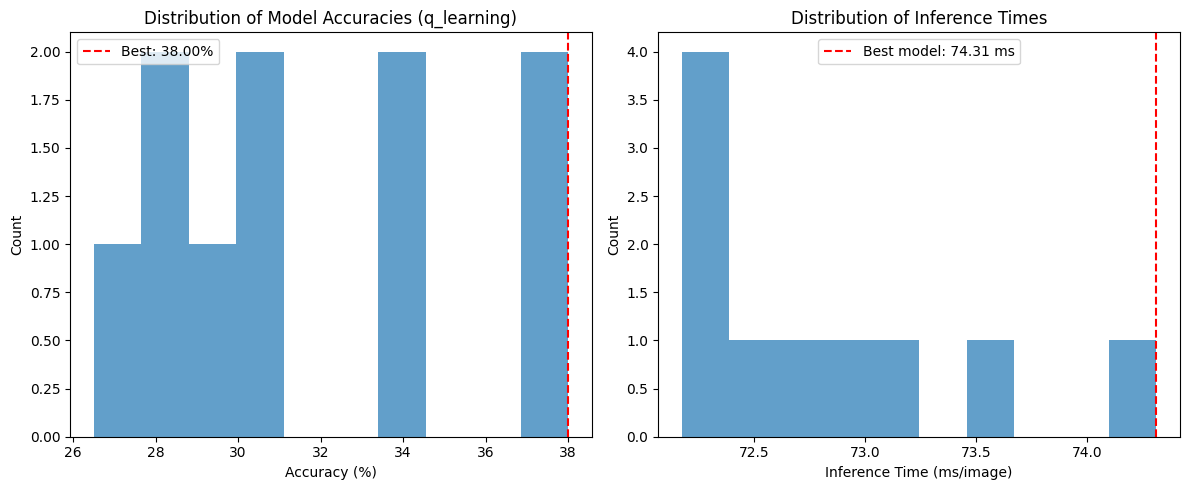

In [12]:
# Plot search results
q_learning_search.plot_search_results()

In [13]:
# Get a summary of the best architecture found
print(q_learning_search.get_best_architecture_summary())

Best Architecture Summary (q_learning):
Accuracy: 38.00%

Convolutional Layers:
Layer 1:
  Operation: conv3x3
  Channels: 3 -> 64
  Activation: elu
  Pooling: None
Layer 2:
  Operation: conv5x5
  Channels: 64 -> 32
  Activation: selu
  Pooling: max_pool2x2
Layer 3:
  Operation: conv7x7
  Channels: 32 -> 64
  Activation: selu
  Pooling: None
Layer 4:
  Operation: conv3x3
  Channels: 64 -> 128
  Activation: relu
  Pooling: avg_pool2x2

Fully Connected Layers:
Layer 1:
  Size: 8192 -> 256
  Activation: elu
  Dropout: 0.0
Layer 2:
  Size: 256 -> 10
  Activation: None
  Dropout: 0.0



## 6. Evolutionary Search Strategies

Evolutionary algorithms mimic natural selection to evolve neural architectures over generations.

Playground example: https://rednuht.org/genetic_cars_2/

### 6.1 Theory

Evolutionary NAS works by:
1. Maintaining a population of architectures
2. Selecting the fittest architectures as parents
3. Creating new architectures through crossover and mutation
4. Replacing the population with the new generation

We'll implement the evolutionary approach:
1. **Simple Genetic Algorithm**: Optimizes for a single objective (accuracy)

### 6.2 Simple Genetic Algorithm Implementation

In [8]:
# Initialize simple genetic algorithm search
simple_ga_search = EvolutionarySearch(
    search_space=search_space,
    method='simple_ga',
    population_size=10,  # Size of the population
    num_generations=5,  # Number of generations
    mutation_rate=0.2,  # Probability of mutation
    crossover_rate=0.5,  # Probability of crossover
    tournament_size=3,  # Size of tournament for selection
    epochs_per_model=5,  # Number of epochs to train each model
    batch_size=64,
    device=device,
    small_subset=True  # Use a small subset of data for faster evaluation
)

In [9]:
# Perform simple genetic algorithm search
best_ga_architecture, best_ga_model = simple_ga_search.search(verbose=True)

Starting SIMPLE GA Search with 10 individuals and 5 generations...
Evaluating 10 individuals...


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [02:54<26:14, 174.97s/it]

New best architecture found! Accuracy: 29.00%


 20%|██        | 2/10 [05:52<23:31, 176.39s/it]

New best architecture found! Accuracy: 37.00%


 30%|███       | 3/10 [08:48<20:34, 176.31s/it]

New best architecture found! Accuracy: 38.50%


 40%|████      | 4/10 [11:53<17:57, 179.59s/it]

New best architecture found! Accuracy: 40.50%


100%|██████████| 10/10 [29:29<00:00, 176.96s/it]


Generation 0: Avg Fitness = 35.80%, Best Fitness = 40.50%

Generation 1/5
Evaluating 10 individuals...


100%|██████████| 10/10 [25:51<00:00, 155.17s/it]


Generation 1: Avg Fitness = 37.60%, Best Fitness = 40.50%

Generation 2/5
Evaluating 10 individuals...


100%|██████████| 10/10 [26:12<00:00, 157.21s/it]


Generation 2: Avg Fitness = 37.40%, Best Fitness = 40.50%

Generation 3/5
Evaluating 10 individuals...


 20%|██        | 2/10 [02:51<11:25, 85.67s/it]

New best architecture found! Accuracy: 43.00%


100%|██████████| 10/10 [26:02<00:00, 156.30s/it]


Generation 3: Avg Fitness = 39.10%, Best Fitness = 43.00%

Generation 4/5
Evaluating 10 individuals...


100%|██████████| 10/10 [26:05<00:00, 156.52s/it]


Generation 4: Avg Fitness = 38.00%, Best Fitness = 43.00%

Generation 5/5
Evaluating 10 individuals...


100%|██████████| 10/10 [25:51<00:00, 155.11s/it]

New best architecture found! Accuracy: 46.50%
Generation 5: Avg Fitness = 39.50%, Best Fitness = 46.50%
Evolutionary Search completed in 159.55 minutes
Best architecture accuracy: 46.50%


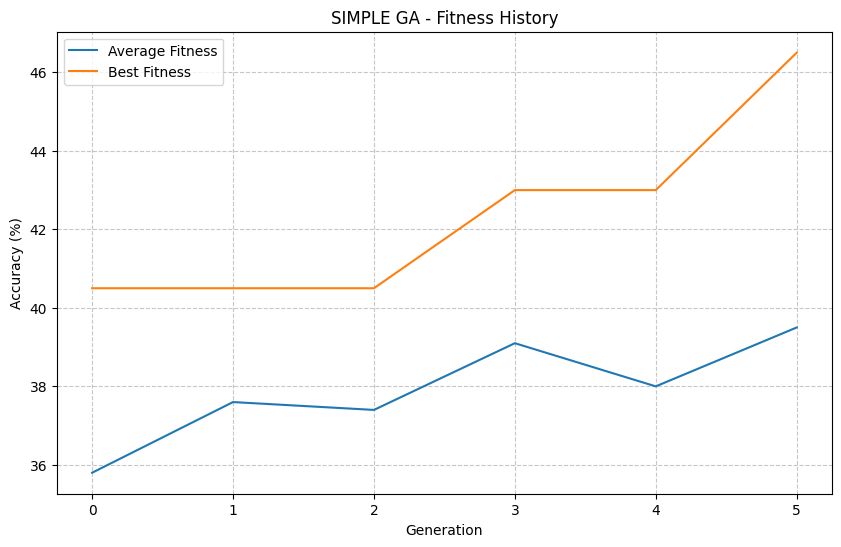

In [10]:
# Plot fitness history
simple_ga_search.plot_fitness_history()

In [11]:
# Get a summary of the best architecture found
print(simple_ga_search.get_best_architecture_summary())

Best Architecture Summary:
Accuracy: 46.50%

Convolutional Layers:
Layer 1:
  Operation: avg_pool3x3
  Channels: 3 -> 32
  Activation: selu
  Pooling: None
Layer 2:
  Operation: max_pool3x3
  Channels: 32 -> 64
  Activation: relu
  Pooling: max_pool2x2

Fully Connected Layers:
Layer 1:
  Size: 16384 -> 256
  Activation: leaky_relu
  Dropout: 0.5
Layer 2:
  Size: 256 -> 10
  Activation: None
  Dropout: 0.0



## 7. Conclusion

In this notebook, we've implemented and compared different Neural Architecture Search (NAS) strategies:

1. **Random Search**: Simple but effective baseline
2. **Reinforcement Learning**: Policy Gradient and Q-learning approaches
3. **Evolutionary Search**: Simple Genetic Algorithm
4. **Gradient-Based Search**: DARTS with first order approximation


### Best Practices:

- **Random Search**: Great baseline and surprisingly effective for small search spaces
- **Reinforcement Learning**: Works well when the reward signal is clear and consistent
- **Evolutionary Search**: Excellent for multi-objective optimization (accuracy vs. efficiency)
- **DARTS**: Efficient for large search spaces but requires careful implementation

### Future Directions:

- Explore more advanced NAS methods like Once-for-All Networks or Neural Architecture Transfer
- Incorporate hardware-aware constraints for edge deployment
- Combine different search strategies for better results
- Apply NAS to different domains beyond image classification